# Anomaly Detection On IP Address Data - An Example using Gaussian Mixture Modeling (GMM) Clustering 

In this notebook, we are going to 

    1. Extract source and destination IP addresses from a network traffic data of millions of packets.
    2. Feature extraction from IP addresses and apply PCA to reduce dimensions to help clusters visualization. 
    3. Use Gaussian Mixture Modeling (GMM) Clustering algorithm to group similar IP addresses in to different clusters.
    4. Find Anomalies/Outliers from the clusters of IP addresses by filtering based on location densities.
    5. Try K-Means Clustering to compare with GMM. 
    6. Conclusion.


##### Import libraries

In [1]:
import datetime
import pandas as pd
import numpy as np

In [2]:
import matplotlib as plt
import matplotlib.pyplot as pyplot

##### Read the packets csv file

In [3]:
df_file = "pcaps.csv"

df = pd.read_csv(df_file, parse_dates=["timestamp"], \
                 dtype=object, index_col=["timestamp"])

print(sorted(df.columns))
print(df.shape)

['Unnamed: 0', 'arpdst', 'arpop', 'arppdst', 'arppsrc', 'arpsrc', 'bootpchaddr', 'bootpciaddr', 'bootpgiaddr', 'bootpop', 'bootpsiaddr', 'bootpyiaddr', 'dhcpoptions', 'dnsopcode', 'edst', 'esrc', 'etype', 'icmpcode', 'icmptype', 'id', 'idst', 'iperrordst', 'iperrorproto', 'iperrorsrc', 'iplen', 'iproto', 'ipttl', 'isrc', 'len', 'ntpmode', 'tdport', 'tsport', 'twindow', 'uerrordst', 'uerrorsrc', 'ulen', 'utdport', 'utsport', 'vlan']
(5998837, 39)


In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Extract source and destination IP addresses from the network traffic data

The data has details of each network packet as a row in the data frame. 

In [5]:
df.head(10)

,Unnamed: 0,id,len,esrc,edst,etype,vlan,isrc,idst,iproto,...,bootpgiaddr,bootpchaddr,dhcpoptions,ntpmode,arpop,arpsrc,arpdst,arppsrc,arppdst,dnsopcode
timestamp,,,,,,,,,,,,,,,,,,,,,
2012-03-16 18:00:00,0,0,117,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,1,1,269,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.254,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,2,2,70,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.251,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,3,3,70,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,4,4,78,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.251,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,5,5,217,00:0c:29:41:4b:e7,00:16:47:9d:f2:c2,33024,120,192.168.202.79,192.168.229.153,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,6,6,70,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.251,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,7,7,178,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.254,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-16 18:00:00,8,8,82,00:16:47:9d:f2:c2,00:0c:29:41:4b:e7,33024,120,192.168.229.251,192.168.202.79,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5998837 entries, 2012-03-16 18:00:00 to 2012-03-16 18:49:57.250000
Data columns (total 39 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Unnamed: 0    object
 1   id            object
 2   len           object
 3   esrc          object
 4   edst          object
 5   etype         object
 6   vlan          object
 7   isrc          object
 8   idst          object
 9   iproto        object
 10  iplen         object
 11  ipttl         object
 12  tsport        object
 13  tdport        object
 14  twindow       object
 15  utsport       object
 16  utdport       object
 17  ulen          object
 18  icmptype      object
 19  icmpcode      object
 20  iperrorsrc    object
 21  iperrordst    object
 22  iperrorproto  object
 23  uerrorsrc     object
 24  uerrordst     object
 25  bootpop       object
 26  bootpciaddr   object
 27  bootpyiaddr   object
 28  bootpsiaddr   object
 29  bootpgiaddr   object
 30  bootpchadd

In [7]:
print(len(df['isrc'].unique()))
print(len(df['idst'].unique()))

188
2674


There are 188 and 2674 unique source and destination IP addresses in the data set. <br>
Let us extract source and destination addresses as separate data frames for analysis.

In [8]:
src_ip_df = df['isrc'].copy()
dst_ip_df = df['idst'].copy()

src_ip_df = src_ip_df.reset_index()
del src_ip_df['timestamp']

dst_ip_df = dst_ip_df.reset_index()
del dst_ip_df['timestamp']

In [9]:
print(src_ip_df.shape)
src_ip_df.head(5)


(5998837, 1)


,isrc
0,192.168.229.254
1,192.168.202.79
2,192.168.202.79
3,192.168.229.254
4,192.168.202.79


In [10]:
print(dst_ip_df.shape)
dst_ip_df.head(5)

(5998837, 1)


,idst
0,192.168.202.79
1,192.168.229.254
2,192.168.229.251
3,192.168.202.79
4,192.168.229.251


In [11]:
# Drop missing items from both data frames
src_ip_df = src_ip_df.dropna().copy()
dst_ip_df = dst_ip_df.dropna().copy()

In [12]:
# Drop duplicates
src_ip_df=src_ip_df.drop_duplicates(['isrc'])
dst_ip_df=dst_ip_df.drop_duplicates(['idst'])
print(src_ip_df.shape)
print(dst_ip_df.shape)

(187, 1)
(2673, 1)


## 2. Feature extraction from IP addresses

We will use the four octets of IP address as features for clustering.

In [13]:
src_ip_df.loc[:, 'oct1'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[0])
src_ip_df.loc[:, 'oct2'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[1])
src_ip_df.loc[:, 'oct3'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[2])
src_ip_df.loc[:, 'oct4'] = src_ip_df['isrc'].apply(lambda x: x.split(".")[3])

dst_ip_df.loc[:, 'oct1'] = dst_ip_df['idst'].apply(lambda x: x.split(".")[0])
dst_ip_df.loc[:, 'oct2'] = dst_ip_df['idst'].apply(lambda x: x.split(".")[1])
dst_ip_df.loc[:, 'oct3'] = dst_ip_df['idst'].apply(lambda x: x.split(".")[2])
dst_ip_df.loc[:, 'oct4'] = dst_ip_df['idst'].apply(lambda x: x.split(".")[3])

In [14]:
src_ip_df = src_ip_df.reset_index()
dst_ip_df = dst_ip_df.reset_index()

In [15]:
print(src_ip_df.head(5))
print()
print(dst_ip_df.head(5))

   index             isrc oct1 oct2 oct3 oct4
0      0  192.168.229.254  192  168  229  254
1      1   192.168.202.79  192  168  202   79
2      6  192.168.229.251  192  168  229  251
3     14  192.168.229.153  192  168  229  153
4     48    192.168.215.1  192  168  215    1

   index             idst oct1 oct2 oct3 oct4
0      0   192.168.202.79  192  168  202   79
1      1  192.168.229.254  192  168  229  254
2      2  192.168.229.251  192  168  229  251
3      5  192.168.229.153  192  168  229  153
4     48       224.0.0.10  224    0    0   10


In [16]:
src_ip_df=src_ip_df.drop(['index'], axis = 1)
dst_ip_df=dst_ip_df.drop(['index'], axis = 1)
dst_ip_df

,idst,oct1,oct2,oct3,oct4
0,192.168.202.79,192,168,202,79
1,192.168.229.254,192,168,229,254
2,192.168.229.251,192,168,229,251
3,192.168.229.153,192,168,229,153
4,224.0.0.10,224,0,0,10
...,...,...,...,...,...
2668,192.168.202.65,192,168,202,65
2669,31.172.30.4,31,172,30,4
2670,209.53.113.221,209,53,113,221
2671,192.168.202.116,192,168,202,116


In [17]:
src_ip_df = src_ip_df.reset_index()
print(src_ip_df.head(5))

dst_ip_df = dst_ip_df.reset_index()
print(src_ip_df.head(5))

   index             isrc oct1 oct2 oct3 oct4
0      0  192.168.229.254  192  168  229  254
1      1   192.168.202.79  192  168  202   79
2      2  192.168.229.251  192  168  229  251
3      3  192.168.229.153  192  168  229  153
4      4    192.168.215.1  192  168  215    1
   index             isrc oct1 oct2 oct3 oct4
0      0  192.168.229.254  192  168  229  254
1      1   192.168.202.79  192  168  202   79
2      2  192.168.229.251  192  168  229  251
3      3  192.168.229.153  192  168  229  153
4      4    192.168.215.1  192  168  215    1


In [18]:
X_matrix_src = np.array(src_ip_df[['oct1', 'oct2', 'oct3', 'oct4']])
print(X_matrix_src.shape)
print(X_matrix_src[0:5])
print()

X_matrix_dst = np.array(dst_ip_df[['oct1', 'oct2', 'oct3', 'oct4']])
print(X_matrix_dst.shape)
print(X_matrix_dst[0:5])

(187, 4)
[['192' '168' '229' '254']
 ['192' '168' '202' '79']
 ['192' '168' '229' '251']
 ['192' '168' '229' '153']
 ['192' '168' '215' '1']]

(2673, 4)
[['192' '168' '202' '79']
 ['192' '168' '229' '254']
 ['192' '168' '229' '251']
 ['192' '168' '229' '153']
 ['224' '0' '0' '10']]


#### Let's apply PCA to reduce the dimensions for cluster visualization

In [19]:
from sklearn.decomposition import PCA

# source
pcas = PCA(n_components=4)
pcas.fit(X_matrix_src)
print(pcas.explained_variance_ratio_)

#destination
pcad = PCA(n_components=4)
pcad.fit(X_matrix_dst)
print(pcad.explained_variance_ratio_)


[0.70015121 0.27151222 0.02561776 0.00271881]
[0.44847647 0.40581775 0.10990379 0.03580199]


We see above that 2 principal components are enough for both src and dest data to explain at least 85% variance. Let's proceed with PCA with 2 components.

In [20]:
pca_src = PCA(n_components=2)
pcas = pca_src.fit_transform(X_matrix_src)

pca_dest = PCA(n_components=2)
pcad = pca_dest.fit_transform(X_matrix_dst)

pcas1=[]
pcas2=[]

pcad1=[]
pcad2=[]


#source
for i in pcas:
    pcas1.append(i[0])
    pcas2.append(i[1])
    
#destination
for i in pcad:
    pcad1.append(i[0])
    pcad2.append(i[1])
    
print(len(pcas1))
print(len(pcas2))

print(len(pcad1))
print(len(pcad2))


187
187
2673
2673


In [21]:
print(pcas.shape)
print(pcad.shape)

(187, 2)
(2673, 2)


Store the two principal components as new features in the source and destination data frames.

In [22]:
src_ip_df['pca1'] = pcas1
src_ip_df['pca2'] = pcas2
print(src_ip_df[:2])
print()
dst_ip_df['pca1'] = pcad1
dst_ip_df['pca2'] = pcad2

print(dst_ip_df[:2])

   index             isrc oct1 oct2 oct3 oct4    pca1    pca2
0      0  192.168.229.254  192  168  229  254  -4.762 187.744
1      1   192.168.202.79  192  168  202   79 -91.854  33.929

   index             idst oct1 oct2 oct3 oct4    pca1    pca2
0      0   192.168.202.79  192  168  202   79 100.201 110.117
1      1  192.168.229.254  192  168  229  254 -46.441 209.185


In [23]:
# Maintain a copy for using for K-Means later.
dst_ip_df_copy = dst_ip_df.copy()
src_ip_df_copy = src_ip_df.copy()

##### Scatter plot of Source IP address data

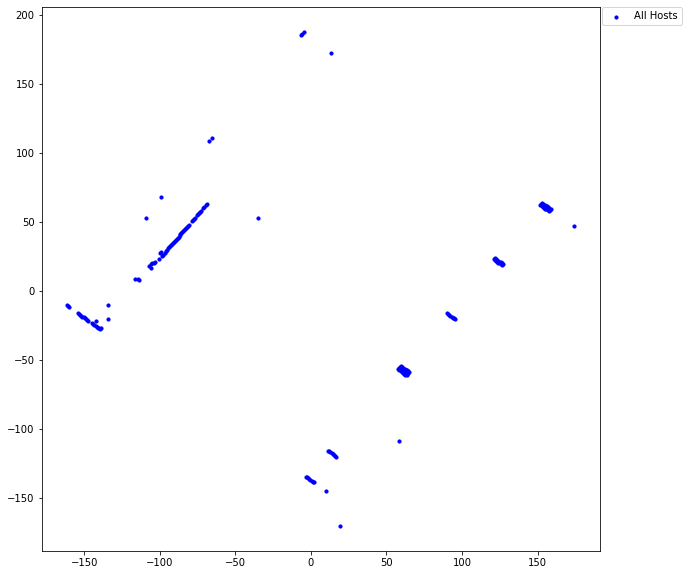

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(src_ip_df['pca1'], src_ip_df['pca2'], s=10, color='blue',label="All Hosts")
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

Visually, it seems like 6 or 7 small clusters are there. Broadly there are two big clusters with ellipsoidal shape and similar orientation.
And the cluster patterns are more ellipsoidal, particularly the ones on the left.

Gaussian Mixture Model (GMM) clustering suits ellipsoidal shaped clusters more than K-Means clustering which suits spherical blobs. GMM also is a probablistic clustering algorithm and provides easier way to detect anomalies. 
Let us try GMM to cluster the source IP addresses.

## 3. Use Gaussian Mixture Modeling (GMM) Clustering algorithm to group similar IP addresses

Use BayesianGaussianMixture to determine first the optimum number of clusters that can be formed.

In [25]:
from sklearn.mixture import BayesianGaussianMixture

# Check 7 clusters
bgms = BayesianGaussianMixture(n_components=7, n_init=10, random_state=100)

bgms.fit(X_matrix_src)
np.round(bgms.weights_, 2)

array([0.47, 0.52, 0.01, 0.  , 0.  , 0.  , 0.  ])

BayesianGaussianMixture gives weights of each cluster. We see that few of the clusters have been eliminated with 0 weight.
So we can try 3 clusters on the data.

In [26]:
bgms = BayesianGaussianMixture(n_components=3, n_init=10, random_state=100)
bgms.fit(X_matrix_src)
print(np.round(bgms.weights_, 2))

[0.53 0.46 0.01]


Observe the means of the clusters, apply PCA and save it in data frame for plotting

In [27]:
print(bgms.means_)
pca_means = pca_src.transform(bgms.means_)
print()
print(pca_means)

[[191.98854859 167.9828769   24.97850159 144.93134559]
 [191.98711716 167.98073651 205.70308719  70.74094526]
 [120.95546619  61.76831501  36.95726324  58.40109023]]

[[ 87.99445487 -23.61248302]
 [-99.87397803  29.7390786 ]
 [ 25.8196479  -93.134321  ]]


In [28]:
means_df_s = pd.DataFrame(pca_means, columns=['pca1','pca2'])
means_df_s

,pca1,pca2
0,87.994,-23.612
1,-99.874,29.739
2,25.820,-93.134


In [29]:
print(bgms.converged_)
print(bgms.n_iter_)

True
5


Predict the clusters for the IP addresses and note it in a separate column

In [30]:
bgms.predict(X_matrix_src)

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

In [31]:
src_ip_df['kcluster']=bgms.predict(X_matrix_src).tolist()
src_ip_df.tail(10)

,index,isrc,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
177,177,192.168.202.86,192,168,202,86,-87.522,39.415,1
178,178,192.168.202.113,192,168,202,113,-70.813,60.577,1
179,179,192.168.201.2,192,168,201,2,-138.721,-27.037,1
180,180,192.168.202.82,192,168,202,82,-89.998,36.280,1
181,181,192.168.202.115,192,168,202,115,-69.575,62.144,1
182,182,192.168.202.69,192,168,202,69,-98.043,26.092,1
183,183,192.168.202.10,192,168,202,10,-134.555,-20.150,1
184,184,192.168.25.254,192,168,25,254,155.476,61.886,0
185,185,192.168.202.116,192,168,202,116,-68.956,62.928,1
186,186,192.168.11.1,192,168,11,1,9.901,-145.042,0


#### Plot the clusters identified by GMM

In [32]:
dfs0=src_ip_df[src_ip_df.kcluster==0]
dfs1=src_ip_df[src_ip_df.kcluster==1]
dfs2=src_ip_df[src_ip_df.kcluster==2]

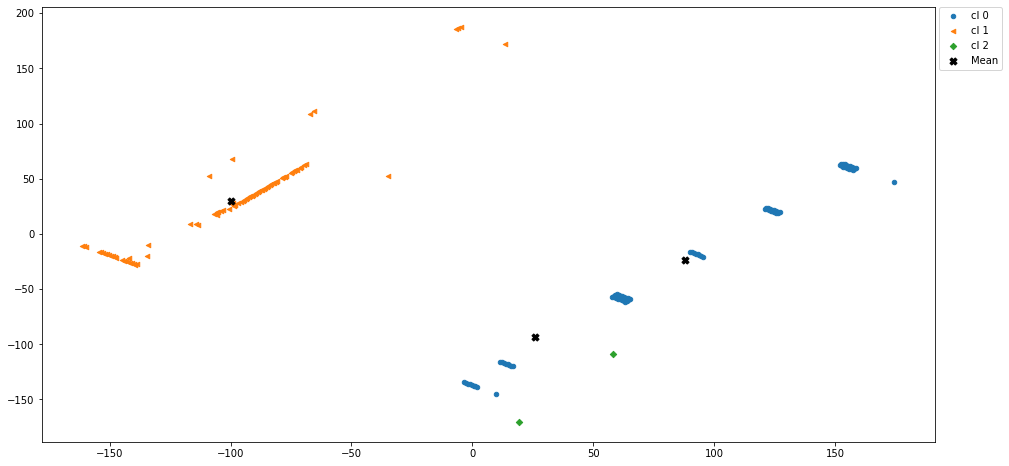

In [33]:
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfs0['pca1'],dfs0['pca2'],s=20,label="cl 0")
pyplot.scatter(dfs1['pca1'],dfs1['pca2'],s=20,marker="<",label="cl 1")
pyplot.scatter(dfs2['pca1'],dfs2['pca2'],s=20,marker="D",label="cl 2")
pyplot.scatter(means_df_s['pca1'],means_df_s['pca2'],s=50,marker="X",label="Mean", color='black')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

##### We can see 3 clusters formed neatly, but do contain some outliers/anomalies. Let us analyze the clusters one by one.

In [34]:
np.round(bgms.weights_, 3)

array([0.526, 0.463, 0.011])

In [35]:
dfs0

,index,isrc,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
6,6,192.168.27.25,192,168,27,25,12.186,-116.361,0
11,11,192.168.27.103,192,168,27,103,60.457,-55.228,0
13,13,192.168.27.253,192,168,27,253,153.286,62.336,0
15,15,192.168.27.152,192,168,27,152,90.781,-16.824,0
16,16,192.168.27.102,192,168,27,102,59.838,-56.012,0
...,...,...,...,...,...,...,...,...,...
174,174,192.168.27.252,192,168,27,252,152.667,61.552,0
175,175,192.168.24.254,192,168,24,254,156.261,61.269,0
176,176,192.168.27.254,192,168,27,254,153.905,63.119,0
184,184,192.168.25.254,192,168,25,254,155.476,61.886,0


In [36]:
print(dfs0.oct1.value_counts())
print(dfs0.oct2.value_counts())
print(dfs0.oct3.value_counts())

192    98
Name: oct1, dtype: int64
168    98
Name: oct2, dtype: int64
28    12
22    12
26    12
24    12
25    12
27    12
23    12
21    12
11     1
1      1
Name: oct3, dtype: int64


Cluster 0 consists of mostly 192.168.(21-27) subnets with a couple of outliers/anomalies.

In [37]:
dfs1

,index,isrc,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
0,0,192.168.229.254,192,168,229,254,-4.762,187.744,1
1,1,192.168.202.79,192,168,202,79,-91.854,33.929,1
2,2,192.168.229.251,192,168,229,251,-6.618,185.393,1
3,3,192.168.229.153,192,168,229,153,-67.267,108.585,1
4,4,192.168.215.1,192,168,215,1,-150.336,-19.183,1
...,...,...,...,...,...,...,...,...,...
180,180,192.168.202.82,192,168,202,82,-89.998,36.280,1
181,181,192.168.202.115,192,168,202,115,-69.575,62.144,1
182,182,192.168.202.69,192,168,202,69,-98.043,26.092,1
183,183,192.168.202.10,192,168,202,10,-134.555,-20.150,1


In [38]:
print(dfs1.oct1.value_counts())
print(dfs1.oct2.value_counts())
print(dfs1.oct3.value_counts())

192    87
Name: oct1, dtype: int64
168    87
Name: oct2, dtype: int64
202    45
229     7
204     7
203     4
201     2
206     2
208     2
207     2
227     2
205     2
218     1
217     1
228     1
211     1
216     1
219     1
220     1
169     1
215     1
212     1
214     1
213     1
Name: oct3, dtype: int64


Cluster 1 consists of mostly 192.168.(200+) subnets.This cluster is not so tight, have a sparsely populated range of third octet which seem to have possible anomalies.

In [39]:
dfs2

,index,isrc,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
77,77,172.19.2.66,172,19,2,66,58.107,-108.918,2
79,79,0.0.0.0,0,0,0,0,19.352,-170.485,2


Cluster 2 consists of only two IP addresses which clearly seem to be anomalies, when compared to the cluster 0 and 1 addresses.

#### So with GMM clustering, we see the following 3 clusters clearly formed from the source IP addreses.

Cluster 0 consists of mostly 192.168.(21-27) subnets with a couple of possible outliers / anomalies. <br>
Cluster 1 consists of mostly 192.168.(200+) subnets. This cluster is not so tight, have a sparsely populated range of third octet which seem to have possible anomalies.<br>
Cluster 2 consists of only two IP addresses which clearly seem to be anomalies, when compared to the cluster 0 and 1 addresses.

#####  Let us separate out anomalies.

## 4. Find Anomalies/Outliers from the clusters of IP addresses

score_samples() method can be used to estimate the density of the data points in the cluster. The greater the score, higher the density.

In [40]:
bgms.score_samples(X_matrix_src)

array([-18.06130508, -11.83967802, -17.89352752, -13.89789845,
       -12.65073122, -11.95320527, -12.68176464, -12.54042121,
       -11.96191222, -12.54893433, -11.83426278, -11.7874739 ,
       -13.40214938, -12.5151538 , -12.57662101, -11.67101517,
       -11.79342878, -11.91477661, -12.5803267 , -11.79952679,
       -11.90641881, -12.68130634, -12.79435258, -13.32537905,
       -12.56396549, -13.2521622 , -12.83914161, -12.53405539,
       -12.53546156, -12.59579456, -12.62370957, -11.87723411,
       -12.6002414 , -12.5362027 , -12.71543494, -12.75311702,
       -11.9300258 , -11.83302575, -11.97091926, -11.90065884,
       -13.13211833, -12.56100093, -12.55266643, -12.4890204 ,
       -11.88834631, -16.78350181, -14.10544149, -13.97745198,
       -11.92888488, -11.84208326, -11.83123902, -11.85861069,
       -11.83576778, -12.50444009, -12.51506077, -12.47284472,
       -17.94915329, -12.94808755, -12.49946289, -11.84478858,
       -12.22606342, -11.86732224, -11.88720049, -11.89

Any instance located in a low-density region can be considered an anomaly in GMM.
We can define a density threshold of say 4%, and consider all the data lying in areas of density below 4th percentile of the densities values as anomalies. 

In [41]:
densities_s = bgms.score_samples(X_matrix_src)
dens_threshold_s = np.percentile(densities_s, 4)

print("Maximum Density : " + str(max(densities_s)))
print("Minimum Density : " + str(min(densities_s)))
print("Threshold Density : " + str(dens_threshold_s))

anomalies_s = X_matrix_src[densities_s < dens_threshold_s]

Maximum Density : -11.657736542696394
Minimum Density : -27.048463652842244
Threshold Density : -14.049126105279296


In [42]:
print(anomalies_s)
print(len(anomalies_s))

[['192' '168' '229' '254']
 ['192' '168' '229' '251']
 ['192' '168' '205' '253']
 ['192' '168' '1' '254']
 ['192' '168' '229' '252']
 ['172' '19' '2' '66']
 ['192' '168' '169' '129']
 ['0' '0' '0' '0']]
8


Create a dataframe for anomalies to help plotting them.

In [43]:
anomalies_df_s = src_ip_df[densities_s < dens_threshold_s]
anomalies_df_s

,index,isrc,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
0,0,192.168.229.254,192,168,229,254,-4.762,187.744,1
2,2,192.168.229.251,192,168,229,251,-6.618,185.393,1
45,45,192.168.205.253,192,168,205,253,13.471,172.154,1
46,46,192.168.1.254,192,168,1,254,174.327,47.079,0
56,56,192.168.229.252,192,168,229,252,-6.000,186.177,1
77,77,172.19.2.66,172,19,2,66,58.107,-108.918,2
78,78,192.168.169.129,192,168,169,129,-34.991,52.758,1
79,79,0.0.0.0,0,0,0,0,19.352,-170.485,2


Plot the clusters again, this time with anomalies

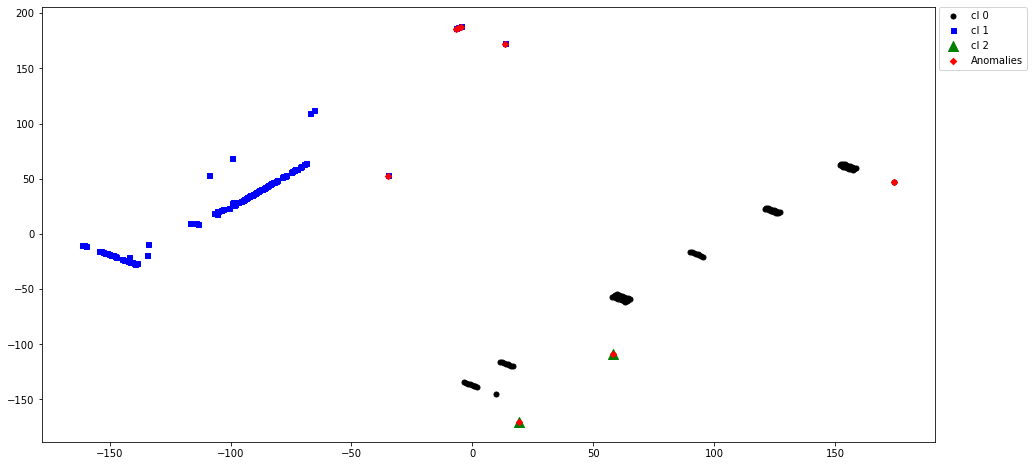

In [44]:
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfs0['pca1'],dfs0['pca2'],s=25,label="cl 0", color='black')
pyplot.scatter(dfs1['pca1'],dfs1['pca2'],s=25,marker=",",label="cl 1", color='blue')
pyplot.scatter(dfs2['pca1'],dfs2['pca2'],s=100,marker="^",label="cl 2", color='green')
pyplot.scatter(anomalies_df_s['pca1'],anomalies_df_s['pca2'],s=20,marker="D",label="Anomalies", color='red')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

In [45]:
list(anomalies_df_s.isrc)

['192.168.229.254',
 '192.168.229.251',
 '192.168.205.253',
 '192.168.1.254',
 '192.168.229.252',
 '172.19.2.66',
 '192.168.169.129',
 '0.0.0.0']

The cluster diagram clearly shows anomalies lying far away from the tight cluster groups.<br>
Also if you compare the anomalies IP addresses with those commonly found in the clusters, you can see striking differences.<br>

For example, many anomalies end with last octet in range >250 i.e towards the end of octet range.<br>
Both addresses of cluster 2 - 172.19.2.66 and 0.0.0.0 are marked anomalies. This is expected looking their values which stand out 
from 192.168. subnet in cluster 0 and 1.<br>
The same case with 192.168.169.129 whose third octet 169 stands apart from the observed range.

#### So, we have successfully used Gaussian Mixture Modeling to cluster the source IP addresses in the packet data and also extracted the possible anomalies/outliers in the addresses used.




### Let us repeat the same exercise with destination IP addresses and see how GMM fares.

###### First visualize the destination IP address principal components by a scatter plot

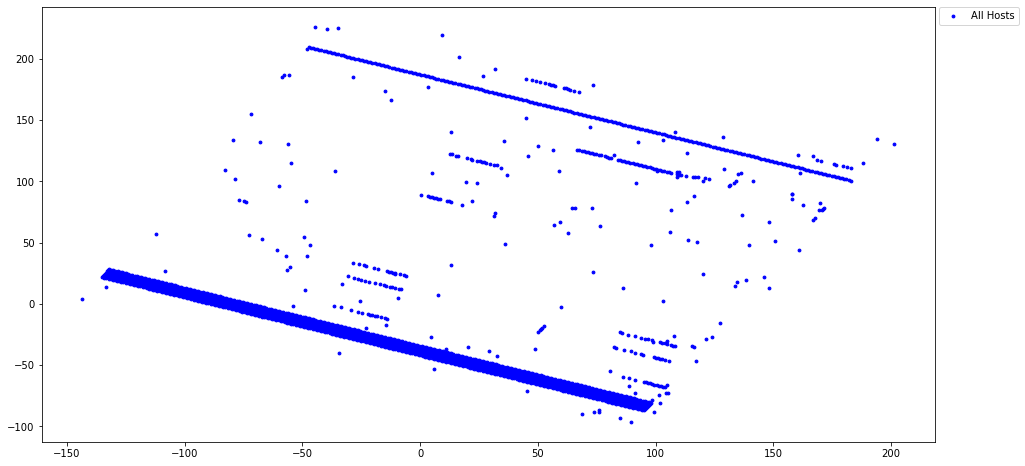

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)

plt.scatter(dst_ip_df['pca1'], dst_ip_df['pca2'], s=8, color='blue',label="All Hosts")
plt.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
plt.show()

The destination IP addresses clearly seem to be more ellipsoidal with at least two long clusters at the top and bottom with similar size, shape and orientations. <br>

Let us try GMM with this data too !


In [47]:
from sklearn.mixture import BayesianGaussianMixture
bgmd = BayesianGaussianMixture(n_components=5, n_init=10, random_state=100)

bgmd.fit(X_matrix_dst)
np.round(bgmd.weights_, 2)

array([0.77, 0.01, 0.1 , 0.  , 0.12])

BayesianGaussianMixture has eliminated one cluster and it looks like 4 clusters will be optimum

In [48]:
bgmd = BayesianGaussianMixture(n_components=4, n_init=10, random_state=100)
bgmd.fit(X_matrix_dst)
np.round(bgmd.weights_, 2)

array([0.1 , 0.77, 0.01, 0.12])

Get the means of the clusters via PCA transformation for visualization

In [49]:
pca_means_dst = pca_dest.transform(bgmd.means_)
means_df_d = pd.DataFrame(pca_means_dst, columns=['pca1','pca2'])
means_df_d

,pca1,pca2
0,43.365,45.369
1,-18.444,-29.308
2,91.749,-58.353
3,73.041,145.646


Predict the clusters of the data set

In [50]:
bgmd.predict(X_matrix_dst)

array([3, 3, 3, ..., 0, 3, 0], dtype=int64)

In [51]:
dst_ip_df['kcluster']=bgmd.predict(X_matrix_dst).tolist()
dst_ip_df.head(10)

,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
0,0,192.168.202.79,192,168,202,79,100.201,110.117,3
1,1,192.168.229.254,192,168,229,254,-46.441,209.185,3
2,2,192.168.229.251,192,168,229,251,-43.731,207.905,3
3,3,192.168.229.153,192,168,229,153,44.769,166.065,3
4,4,224.0.0.10,224,0,0,10,84.847,-93.207,0
5,5,192.168.27.25,192,168,27,25,75.115,-70.795,1
6,6,192.168.202.100,192,168,202,100,81.237,119.083,3
7,7,192.168.27.253,192,168,27,253,-130.784,26.545,1
8,8,192.168.169.254,192,168,169,254,-71.761,155.063,3
9,9,192.168.27.152,192,168,27,152,-39.574,-16.575,1


In [52]:
dfd0=dst_ip_df[dst_ip_df.kcluster==0]
dfd1=dst_ip_df[dst_ip_df.kcluster==1]
dfd2=dst_ip_df[dst_ip_df.kcluster==2]
dfd3=dst_ip_df[dst_ip_df.kcluster==3]

In [53]:

### If you want to see the probabilities of each cluster for each IP address, uncomment the below

#bgmd.predict_proba(X_matrix_dst).shape

#proba_df_d = pd.DataFrame(bgmd.predict_proba(X_matrix_dst), columns=['C0_prob','C1_prob', 'C2_prob','C3_prob'])
#proba_df_d = proba_df_d.reset_index()
#proba_df_d.head(10)

In [54]:
### If you want to see the probabilities of each cluster alongside each IP address, uncomment the below

#dst_ip_df = pd.merge(dst_ip_df, proba_df_d, how='inner', on='index')
#dst_ip_df.head(10)


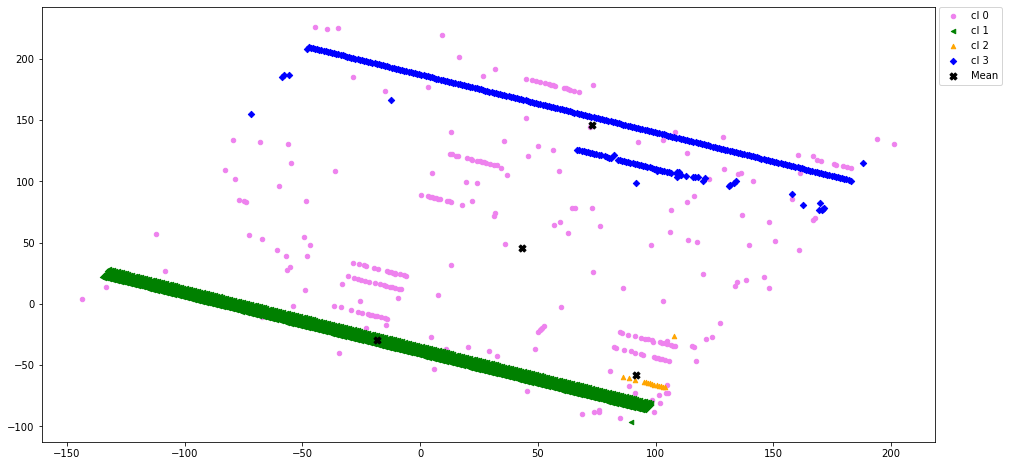

In [55]:
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfd0['pca1'],dfd0['pca2'],s=20,label="cl 0", color='violet')
pyplot.scatter(dfd1['pca1'],dfd1['pca2'],s=20,marker="<",label="cl 1", color='green')
pyplot.scatter(dfd2['pca1'],dfd2['pca2'],s=20,marker="^",label="cl 2", color='orange')
pyplot.scatter(dfd3['pca1'],dfd3['pca2'],s=20,marker="D",label="cl 3", color='blue')
pyplot.scatter(means_df_d['pca1'],means_df_d['pca2'],s=50,marker="X",label="Mean", color='black')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

We see GMM has decently clustered the IP addresses in to three large clusters and one small cluster (cl 2 ).
Important to note that GMM has respected the ellipsoidal shapes and orientation of the clusters well. 
##### This is what differentiates GMM from K-Means which assumes clusters to be spherical ( which we will see subsequently below ). <br>


In [56]:
# Weights of the clusters
np.round(bgmd.weights_, 2)

array([0.1 , 0.77, 0.01, 0.12])

Let us go over each cluster and analyze

In [57]:
# Cluster 0
print(dfd0.shape)
dfd0.head(20)

(278, 9)


,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
4,4,224.0.0.10,224,0,0,10,84.847,-93.207,0
10,10,64.4.23.149,64,4,23,149,-22.078,-8.396,0
14,14,157.56.52.15,157,56,52,15,102.960,-45.208,0
18,18,157.55.56.150,157,55,56,150,-17.210,16.091,0
19,19,157.55.235.162,157,55,235,162,47.493,182.681,0
21,21,178.63.97.34,178,63,97,34,103.203,2.458,0
24,24,149.5.45.166,149,5,45,166,-33.046,16.025,0
28,28,172.19.1.100,172,19,1,100,5.893,-53.331,0
30,30,10.7.136.159,10,7,136,159,19.488,99.306,0
31,31,157.55.56.160,157,55,56,160,-26.241,20.361,0


In [58]:
dfd0['oct1'].value_counts()

157    56
111    29
213    17
64     16
10     12
       ..
154     1
84      1
109     1
3       1
137     1
Name: oct1, Length: 65, dtype: int64

##### Cluster 0 appears very scattered with addresses from a wide range of subnets.<br> We can also see this from the clusters plot above. <br> Looks like it will contain a lot of anomalies. 

In [59]:
# Cluster 1
print(dfd1.shape)
dfd1.head(20)

(2049, 9)


,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
5,5,192.168.27.25,192,168,27,25,75.115,-70.795,1
7,7,192.168.27.253,192,168,27,253,-130.784,26.545,1
9,9,192.168.27.152,192,168,27,152,-39.574,-16.575,1
11,11,192.168.27.102,192,168,27,102,5.579,-37.921,1
12,12,192.168.27.103,192,168,27,103,4.676,-37.494,1
13,13,192.168.27.101,192,168,27,101,6.482,-38.348,1
15,15,192.168.27.1,192,168,27,1,96.788,-81.041,1
16,16,192.168.27.203,192,168,27,203,-85.631,5.198,1
17,17,192.168.27.202,192,168,27,202,-84.727,4.772,1
27,27,192.168.21.203,192,168,21,203,-88.163,-0.214,1


In [60]:
print(dfd1['oct1'].value_counts())
print(dfd1['oct2'].value_counts())
print(dfd1['oct3'].value_counts())

192    2049
Name: oct1, dtype: int64
168    2049
Name: oct2, dtype: int64
28    256
25    256
27    256
24    256
23    256
26    256
21    256
22    256
10      1
Name: oct3, dtype: int64


##### Cluster 1 is very tight containing almost only 192.168.[21-28]  subnet addresses. <br> This cluster is the most populated from all the four clusters.<br> Only one outlier - 192.168.10. which we can see sitting far in the cluster plot too.

In [61]:
# Cluster 2
print(dfd2.shape)
dfd2.head(20)

(15, 9)


,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
185,185,183.182.82.14,183,182,82,14,107.989,-26.379,2
227,227,173.194.43.4,173,194,43,4,100.459,-66.186,2
230,230,173.194.43.20,173,194,43,20,86.010,-59.355,2
245,245,173.194.43.10,173,194,43,10,95.041,-63.624,2
2640,2640,173.194.43.1,173,194,43,1,103.168,-67.466,2
2641,2641,173.194.43.8,173,194,43,8,96.847,-64.478,2
2642,2642,173.194.43.7,173,194,43,7,97.750,-64.905,2
2643,2643,173.194.43.14,173,194,43,14,91.428,-61.916,2
2644,2644,173.194.43.6,173,194,43,6,98.653,-65.332,2
2645,2645,173.194.43.3,173,194,43,3,101.362,-66.613,2


In [62]:
print(dfd2['oct1'].value_counts())
print(dfd2['oct2'].value_counts())
print(dfd2['oct3'].value_counts())

173    14
183     1
Name: oct1, dtype: int64
194    14
182     1
Name: oct2, dtype: int64
43    14
82     1
Name: oct3, dtype: int64


##### Cluster 2 is small, very tight containing 173.194.43  subnet addresses. <br>This cluster is the least populated from all the four clusters.<br> One outlier 183.182.82.14 is seen which is also seen standing out in the cluster plot above.

In [63]:
# Cluster 3
print(dfd3.shape)
dfd3.head(20)

(331, 9)


,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
0,0,192.168.202.79,192,168,202,79,100.201,110.117,3
1,1,192.168.229.254,192,168,229,254,-46.441,209.185,3
2,2,192.168.229.251,192,168,229,251,-43.731,207.905,3
3,3,192.168.229.153,192,168,229,153,44.769,166.065,3
6,6,192.168.202.100,192,168,202,100,81.237,119.083,3
8,8,192.168.169.254,192,168,169,254,-71.761,155.063,3
20,20,192.168.202.76,192,168,202,76,102.911,108.837,3
22,22,192.168.202.89,192,168,202,89,91.171,114.387,3
23,23,192.168.229.101,192,168,229,101,91.728,143.865,3
25,25,192.168.202.255,192,168,202,255,-58.738,185.257,3


In [64]:
print(dfd3['oct1'].value_counts())
print(dfd3['oct2'].value_counts())
print(dfd3['oct3'].value_counts())

192    330
194      1
Name: oct1, dtype: int64
168    330
165      1
Name: oct2, dtype: int64
229    256
202     50
204      7
203      4
205      3
201      2
208      2
188      1
207      1
227      1
206      1
200      1
169      1
244      1
Name: oct3, dtype: int64


In [65]:
print(dfd3[dfd3['oct1']=='194'])

     index            idst oct1 oct2 oct3 oct4   pca1   pca2  kcluster
144    144  194.165.188.82  194  165  188   82 91.638 98.875         3


##### Cluster 3 is tight containing mostly 192.168.[>200]  subnet addresses. One outlier can be seen above 194.165.188.82 which differs in the first octet itself.


So with GMM clustering, we see the following 4 clusters clearly formed from the destination IP addresses.

Cluster 0 appears very scattered with addresses from a wide range of subnets. Looks like it will contain a lot of anomalies. <br>
Cluster 1 is very tight containing almost only 192.168.[21-28]  subnet addresses. <br>
Cluster 2 is small, very tight containing 173.194.43  subnet addresses. <br>
Cluster 3 is tight containing mostly 192.168.[>200]  subnet addresses.

Let us separate out anomalies.

In [66]:
bgmd.score_samples(X_matrix_dst)

array([-14.68607244, -15.4592669 , -15.38210898, ..., -25.13039313,
       -14.63746441, -26.1783574 ])

In [67]:
densities_d = bgmd.score_samples(X_matrix_dst)
dens_threshold_d = np.percentile(densities_d, 4)
print("Maximum Density: " + str(max(densities_d)))
print("Minimum Density: " + str(min(densities_d)))
print("Threshold Density: " + str(dens_threshold_d))

anomalies_d = X_matrix_dst[densities_d < dens_threshold_d]

Maximum Density: -8.40416989144428
Minimum Density: -28.704807017163787
Threshold Density: -25.026364347639266


In [68]:
print(len(anomalies_d))

107


In [69]:
anomalies_df_d = dst_ip_df[densities_d < dens_threshold_d]
anomalies_df_d

,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
4,4,224.0.0.10,224,0,0,10,84.847,-93.207,0
28,28,172.19.1.100,172,19,1,100,5.893,-53.331,0
30,30,10.7.136.159,10,7,136,159,19.488,99.306,0
33,33,10.61.9.10,10,61,9,10,97.426,-81.867,0
34,34,10.7.137.108,10,7,137,108,65.966,78.434,0
...,...,...,...,...,...,...,...,...,...
2657,2657,64.134.255.10,64,134,255,10,194.077,134.311,0
2660,2660,208.29.69.210,208,29,69,210,-67.359,53.303,0
2669,2669,31.172.30.4,31,172,30,4,104.297,-72.303,0
2670,2670,209.53.113.221,209,53,113,221,-60.125,96.325,0


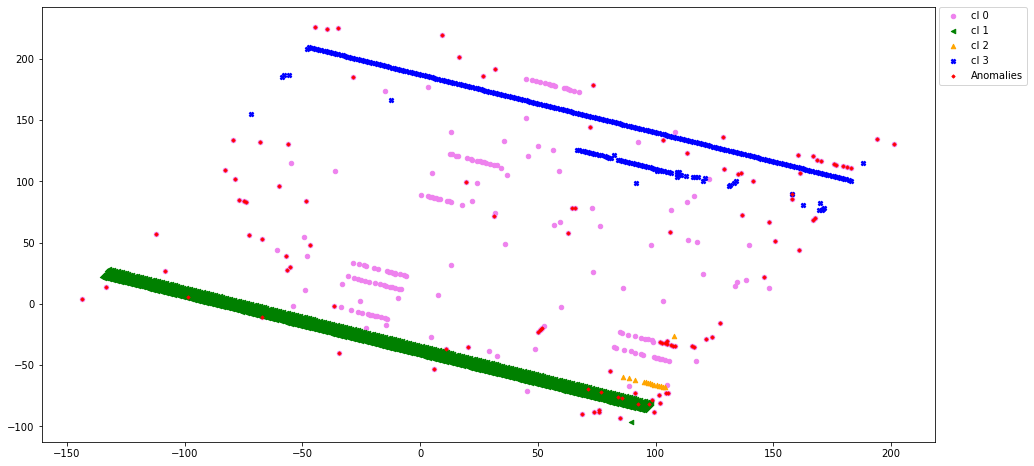

In [70]:
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfd0['pca1'],dfd0['pca2'],s=20,label="cl 0", color='violet')
pyplot.scatter(dfd1['pca1'],dfd1['pca2'],s=20,marker="<",label="cl 1", color='green')
pyplot.scatter(dfd2['pca1'],dfd2['pca2'],s=20,marker="^",label="cl 2", color='orange')
pyplot.scatter(dfd3['pca1'],dfd3['pca2'],s=20,marker="X",label="cl 3", color='blue')
pyplot.scatter(anomalies_df_d['pca1'],anomalies_df_d['pca2'],s=5,marker="D",label="Anomalies", color='red')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

In [71]:
print(len(anomalies_df_d))
anomalies_df_d[anomalies_df_d['kcluster']==0]

107


,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
4,4,224.0.0.10,224,0,0,10,84.847,-93.207,0
28,28,172.19.1.100,172,19,1,100,5.893,-53.331,0
30,30,10.7.136.159,10,7,136,159,19.488,99.306,0
33,33,10.61.9.10,10,61,9,10,97.426,-81.867,0
34,34,10.7.137.108,10,7,137,108,65.966,78.434,0
...,...,...,...,...,...,...,...,...,...
2657,2657,64.134.255.10,64,134,255,10,194.077,134.311,0
2660,2660,208.29.69.210,208,29,69,210,-67.359,53.303,0
2669,2669,31.172.30.4,31,172,30,4,104.297,-72.303,0
2670,2670,209.53.113.221,209,53,113,221,-60.125,96.325,0


We can see that all anomalies are part of the widely scattered cluster 0. And we can see their locations plotted above.

##### So, we have successfully clustered both source ip addresses and destination ip addresses using GMM and also detected anomalies in the process.

Let us see how K-Means algorithm can seggregate the destination IP addresses 

## 5. Try K-Means Clustering On Destination IP addresses and compare with GMM.

In [72]:
## Take a separate copy of destination IP data for K-Means.
dst_ip_df2 = dst_ip_df_copy.copy()

##### Estimate optimum number of clusters by trying KMeans with different number of clusters and checking the 'elbow' point

In [73]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

tightness = []
possibleKs = range(1,10)

for k in possibleKs:
    km = KMeans(n_clusters=k).fit(X_matrix_dst)
    tightness.append(sum(np.min(cdist(X_matrix_dst, \
         km.cluster_centers_, 'euclidean'), axis=1)) / X_matrix_dst.shape[0])

C:\Users\rajar\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


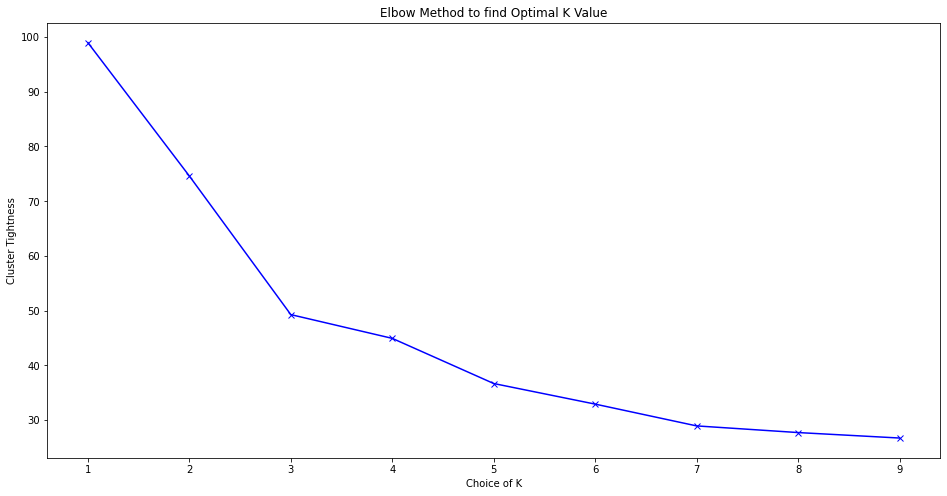

In [74]:
pyplot.plot(possibleKs, tightness, 'bx-')
pyplot.xlabel('Choice of K')
pyplot.ylabel('Cluster Tightness')
pyplot.title('Elbow Method to find Optimal K Value')
pyplot.show()

There are multiple elbow points in the plot - 3,5,6 etc. Let us go with 5 as the optimum number of clusters needed.

In [75]:
# Fit KMeans with 5 clusters, predict the clusters and save the labels as a new column.
kclusters=5
kms = KMeans(n_clusters=kclusters,n_init=200,random_state=0)

kms.fit_predict(X_matrix_dst)

dst_ip_df2['kcluster']=kms.labels_.tolist()

Find the cluster centers and PCA transform the same for visualization

In [76]:
C_matrix=kms.cluster_centers_
print(C_matrix.shape)
print(C_matrix)

pca_centers = pca_dest.transform(C_matrix)
print()
print(pca_centers)
centers_df = pd.DataFrame(pca_centers, columns=['pca1', 'pca2'])
centers_df

(5, 4)
[[190.49428571 167.22142857  26.16857143 213.30142857]
 [187.96814404 169.57063712  26.50969529  39.78254848]
 [187.81909548 163.47487437 220.66080402 120.97236181]
 [190.26441632 169.14908579  25.51054852 127.48804501]
 [118.66197183  38.97887324  85.          95.21126761]]

[[-95.15489559   8.93624303]
 [ 61.70027848 -64.88888188]
 [ 70.66424422 145.25022475]
 [-18.03236631 -28.39360709]
 [ 47.58781052  20.93428018]]


,pca1,pca2
0,-95.155,8.936
1,61.700,-64.889
2,70.664,145.250
3,-18.032,-28.394
4,47.588,20.934


In [77]:
dst_ip_df2

,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
0,0,192.168.202.79,192,168,202,79,100.201,110.117,2
1,1,192.168.229.254,192,168,229,254,-46.441,209.185,2
2,2,192.168.229.251,192,168,229,251,-43.731,207.905,2
3,3,192.168.229.153,192,168,229,153,44.769,166.065,2
4,4,224.0.0.10,224,0,0,10,84.847,-93.207,4
...,...,...,...,...,...,...,...,...,...
2668,2668,192.168.202.65,192,168,202,65,112.844,104.140,2
2669,2669,31.172.30.4,31,172,30,4,104.297,-72.303,1
2670,2670,209.53.113.221,209,53,113,221,-60.125,96.325,0
2671,2671,192.168.202.116,192,168,202,116,66.788,125.914,2


Separate DataFrames for each cluster identified

In [78]:
dfkms0=dst_ip_df2[dst_ip_df2.kcluster==0]
dfkms1=dst_ip_df2[dst_ip_df2.kcluster==1]
dfkms2=dst_ip_df2[dst_ip_df2.kcluster==2]
dfkms3=dst_ip_df2[dst_ip_df2.kcluster==3]
dfkms4=dst_ip_df2[dst_ip_df2.kcluster==4]

##### Plot the clusters

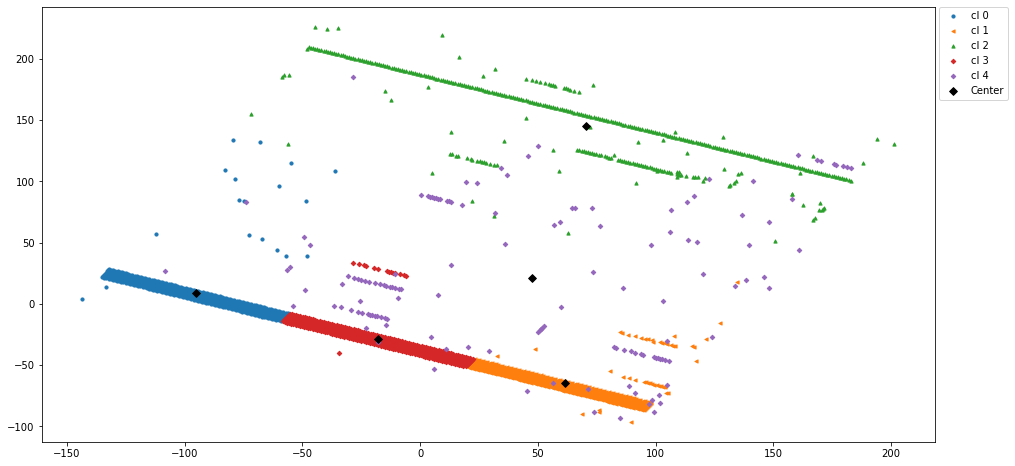

In [79]:
plt.rcParams["figure.figsize"] = (16,8)
pyplot.scatter(dfkms0['pca1'],dfkms0['pca2'],s=10,label="cl 0")
pyplot.scatter(dfkms1['pca1'],dfkms1['pca2'],s=10,marker="<",label="cl 1")
pyplot.scatter(dfkms2['pca1'],dfkms2['pca2'],s=10,marker="^",label="cl 2")
pyplot.scatter(dfkms3['pca1'],dfkms3['pca2'],s=10,marker="D",label="cl 3")
pyplot.scatter(dfkms4['pca1'],dfkms4['pca2'],s=10,marker="D",label="cl 4")
pyplot.scatter(centers_df['pca1'], centers_df['pca2'],s=30,marker="D",label="Center", color='Black')

pyplot.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0.)
pyplot.show()

We can see that the clustering done by K-Means is different from that by GMM.
1. The ellipsoidal data points at the bottom has been split in to 3 clusters while GMM clustered them as a single big cluster.
2. The clusters don't seem to be clearly split and contains mixed data points from the scattered ones.

Overall the clustering is not as good and clearly demarcated as done by GMM. This should be because K-Means is based on cluster center method which suits more to spherical blobs of data and not ellipsoidal shapes of different sizes and orientations. <br>

Let us go through each individual cluster and understand more.

In [80]:
# Cluster 0
dfkms0

,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
7,7,192.168.27.253,192,168,27,253,-130.784,26.545,0
16,16,192.168.27.203,192,168,27,203,-85.631,5.198,0
17,17,192.168.27.202,192,168,27,202,-84.727,4.772,0
27,27,192.168.21.203,192,168,21,203,-88.163,-0.214,0
35,35,192.168.28.254,192,168,28,254,-131.265,27.874,0
...,...,...,...,...,...,...,...,...,...
2637,2637,192.168.27.251,192,168,27,251,-128.978,25.691,0
2638,2638,192.168.27.252,192,168,27,252,-129.881,26.118,0
2639,2639,192.168.27.255,192,168,27,255,-132.590,27.399,0
2660,2660,208.29.69.210,208,29,69,210,-67.359,53.303,0


In [81]:
print(dfkms0.oct1.value_counts())
print()
print(dfkms0.oct2.value_counts())
print()
print(dfkms0.oct3.value_counts())

192    682
88       2
195      2
208      2
159      1
93       1
87       1
78       1
84       1
172      1
217      1
91       1
72       1
81       1
209      1
77       1
Name: oct1, dtype: int64

168    681
198      2
29       2
99       1
169      1
229      1
209      1
128      1
142      1
19       1
53       1
115      1
228      1
207      1
42       1
80       1
231      1
242      1
Name: oct2, dtype: int64

23     85
26     85
25     85
21     85
24     85
28     85
22     85
27     85
100     2
69      2
113     2
66      1
20      1
111     1
142     1
136     1
65      1
1       1
60      1
2       1
117     1
75      1
10      1
152     1
137     1
Name: oct3, dtype: int64


##### Looking at the cluster 0 first octet itself, we can see it contains mix of subnets. Though majorly it consists of 192.168, it also contains 208. , 195. etc.  Looking at the second and third octets, it looks like this cluster contains one part of 192.168.[21-28] subnets.

In [82]:
# Cluster 1
dfkms1

,index,idst,oct1,oct2,oct3,oct4,pca1,pca2,kcluster
5,5,192.168.27.25,192,168,27,25,75.115,-70.795,1
15,15,192.168.27.1,192,168,27,1,96.788,-81.041,1
44,44,156.154.70.22,156,154,70,22,98.806,-31.398,1
58,58,82.146.39.68,82,146,39,68,48.848,-36.992,1
61,61,111.221.74.19,111,221,74,19,102.018,-31.403,1
...,...,...,...,...,...,...,...,...,...
2650,2650,173.194.43.2,173,194,43,2,102.265,-67.039,1
2652,2652,173.194.43.0,173,194,43,0,104.071,-67.893,1
2659,2659,173.194.43.17,173,194,43,17,88.719,-60.636,1
2661,2661,192.168.10.1,192,168,10,1,89.614,-96.376,1


In [83]:
print(dfkms1.oct1.value_counts())
print()
print(dfkms1.oct2.value_counts())
print()
print(dfkms1.oct3.value_counts())

192    675
111     15
173     14
17       4
31       2
178      2
110      1
193      1
213      1
183      1
82       1
109      1
156      1
83       1
194      1
217      1
Name: oct1, dtype: int64

168    675
221     15
194     14
151      3
255      2
172      2
154      1
209      1
146      1
79       1
76       1
140      1
201      1
88       1
171      1
246      1
182      1
Name: oct2, dtype: int64

28     85
24     84
23     84
26     84
27     84
25     84
21     84
22     84
74     15
43     14
16      3
30      2
83      2
6       2
85      1
131     1
4       1
59      1
19      1
100     1
39      1
51      1
82      1
10      1
70      1
Name: oct3, dtype: int64


##### Looking at the cluster 1 first octet itself, we can see this cluster also contains mix of subnets. Though majorly it consists of 192.168, it also contains 111. , 173. etc.  Looking at the second and third octets, it looks like this cluster contains another part of 192.168.[21-28] subnets.


So, we clearly see that K-Means has broken a homogenous cluster of 192.168.[21-28] subnet IP addresses in to three smaller clusters and also mixed them up with other dissimilar IP addresses from the scattered set.

But if you recall, GMM had finely segregated all 192.168.[21-28] subnet addresses in to one cluster (Cluster 1) and did not mix up other IP addresses.
So clustering by GMM has delivered better results than K-Means for the ellipsoidal shaped groups as expected.


## 6. Conclusion

1. We used both GMM and K-Means clustering algorithms to cluster IP addresses found in the data set.
2. We saw that GMM delivered better results particularly for destination IP addresses by clearly demarcating the ellipsoidal data blobs than K-Means.
3. In the process, we also detected anomalies within the IP addresses used.
